In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


 # Capstone Project
 You're ready to put into practice everything you've learned so far.

First: Go out and find a dataset of interest. It could be from one of our recommended resources, some other aggregation, or scraped yourself. Just make sure it has lots of variables in it, including an outcome of interest to you.

Second: Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

Third: Model your outcome of interest. You should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power and experiment with both.

So, here is the deliverable: Prepare a slide deck and 15 minute presentation that guides viewers through your model. Be sure to cover a few specific things:

A specified research question your model addresses
How you chose your model specification and what alternatives you compared it to
The practical uses of your model for an audience of interest
Any weak points or shortcomings of your model
This presentation is not a drill. You'll be presenting this slide deck live to a group as the culmination of your work in the last two supervised learning units. As a secondary matter, your slides and / or the Jupyter notebook you use or adapt them into should be worthy of inclusion as examples of your work product when applying to jobs.

In [87]:
import os
from IPython import get_ipython
import pandas as pd
pd.set_option('float_format', '{:.2f}'.format)
import pandas_profiling as pp
import numpy as np
import datetime as dt   
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)
import seaborn as sns
# Load models
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.naive_bayes import BernoulliNB

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.decomposition import PCA 

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [88]:
# Source: https://www.kaggle.com/brittabettendorf/berlin-airbnb-data
df = pd.read_csv("listings.csv")
## pp.ProfileReport(df, check_correlation=True).to_file(outputfile="Main/3.7_ProfileOfBerlinAirBnB_RAW.html")
# See the webpage at: https://github.com/RobKnop/ThinkfulDataScienceBootcamp/blob/master/Main/3.7_ProfileOfBerlinAirBnB_RAW.html

 ### Variable descriptions
 * id
 * name
 * host_id
 * host_name
 * neighbourhood_group
 * neighbourhood
 * latitude
 * longitude
 * room_type
 * price
 * minimum_nights
 * number_of_reviews
 * last_review
 * reviews_per_month
 * calculated_host_listings_count
 * availability_365

In [89]:
# Feature Engineering and Selection (Round 1)
df['last_review'] = pd.to_datetime(df['last_review'])
df['days_since_last_review'] = (df['last_review'] - dt.datetime(2018, 12, 31)).dt.days
df['y_price'] = df['price']

# Drop unnecessary columns
df = df.drop(columns=[
    'name', # we won't do any NLP here
    'last_review', # already converted into 'days_since_last_review'
    'price', # was copied into 'y_price'
    'id', # just a increasing number
])

# Cleaning: Get rid of outliers
# Drop examples where 
# the price is higher than 500€ (0.1% of all data)
# and lower than 10€
df = df[df['y_price'] > 10] # 22522 - 22491 = 31 --> under 0.1% of all data
df = df[df['y_price'] < 500] # 22491 - 22405 = 86 --> under 0.4% of all data
df = df[df['minimum_nights'] < 500] # 22405 - 22399 = 6 --> under 0.1% of all data


In [90]:
plt.figure(figsize=(30, 30),)

df.sort_values(by=['minimum_nights'])
plt.subplot(3, 3, 1)
plt.scatter(df['minimum_nights'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of nights', font)
plt.title('Minimum nights to stay', font)

df.sort_values(by=['number_of_reviews'])
plt.subplot(3, 3, 2)
plt.scatter(df['number_of_reviews'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of reviews', font)
plt.title('Reviews count', font)

df.sort_values(by=['calculated_host_listings_count'])
plt.subplot(3, 3, 3)
plt.scatter(df['calculated_host_listings_count'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of listings', font)
plt.title('Host listings count', font)

df.sort_values(by=['availability_365'])
plt.subplot(3, 3, 4)
plt.scatter(df['availability_365'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of days', font)
plt.title('All year availability', font)

df.sort_values(by=['days_since_last_review'])
plt.subplot(3, 3, 5)
plt.scatter(df['days_since_last_review'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of days', font)
plt.title('Days since last review', font)

df.sort_values(by=['reviews_per_month'])
plt.subplot(3, 3, 6)
plt.scatter(df['reviews_per_month'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of reviews per month', font)
plt.title('Review per month', font)

plt.subplot(3, 3, 7)
plt.scatter(df['latitude'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('latitude in degrees', font)
plt.title('Latitude', font)

plt.subplot(3, 3, 8)
plt.scatter(df['longitude'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('longitude in degrees', font)
plt.title('Longitude', font)

plt.savefig('Main/3.7_Viz_Numeric_Features.png', dpi=100)
plt.close()

                                host_id  latitude  longitude  minimum_nights  \
host_id                            1.00      0.01      -0.04           -0.06   
latitude                           0.01      1.00      -0.11            0.02   
longitude                         -0.04     -0.11       1.00           -0.06   
minimum_nights                    -0.06      0.02      -0.06            1.00   
number_of_reviews                 -0.15      0.04      -0.02           -0.04   
reviews_per_month                  0.18      0.04      -0.04           -0.08   
calculated_host_listings_count    -0.05      0.04      -0.04            0.06   
availability_365                  -0.01      0.01      -0.08            0.18   
days_since_last_review             0.18      0.02      -0.04           -0.05   
y_price                           -0.01      0.04      -0.05           -0.00   

                                number_of_reviews  reviews_per_month  \
host_id                                     -0.

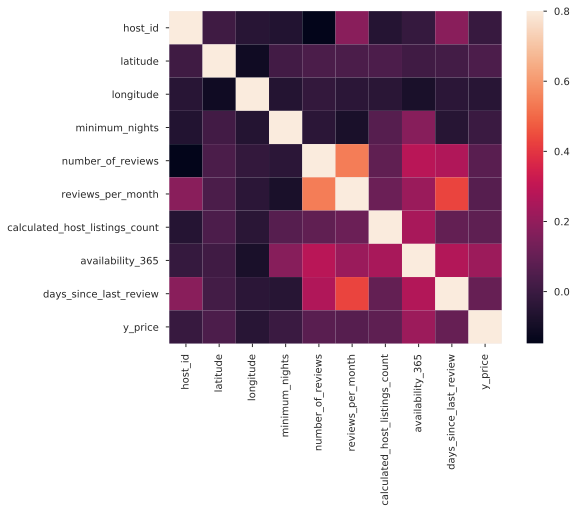

In [91]:
# Cleaning: Fill NaNs
values_to_fill = {
    'days_since_last_review': df.days_since_last_review.mean(), 
    'reviews_per_month': df.reviews_per_month.mean(),
    'latitude': df.latitude.mean(),
    'longitude': df.longitude.mean()
    }
df = df.fillna(value=values_to_fill)

# Do second data profile report on cleaned data
pp.ProfileReport(df, check_correlation=True, pool_size=15).to_file(outputfile="Main/3.7_ProfileOfBerlinAirBnB_CLEAN.html")
# See the webpage at: https://github.com/RobKnop/ThinkfulDataScienceBootcamp/blob/master/Main/3.7_ProfileOfBerlinAirBnB_CLEAN.html

# Make the correlation matrix.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(9, 6))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

 #### Findings
 1. Correlation to y (price) is low:
 2. Multicollinearity is low

 #### Our key evaluation metric to optimize on is root mean squared error

 #### Models to try:
 1. Linear Regression
 4. RandomForestRegressor
 5. KNN
 6. Support Vector Machine
 7. GradientBoosting Regression
 8. (Also use of KSelectBest, GridSearch, PCA)

In [92]:
# Normalize
mm_scaler = MinMaxScaler()
df[['longitude']] = mm_scaler.fit_transform(df[['longitude']].values)
df[['latitude']] = mm_scaler.fit_transform(df[['latitude']].values)
df[['minimum_nights']] = mm_scaler.fit_transform(df[['minimum_nights']].values)
df[['number_of_reviews']] = mm_scaler.fit_transform(df[['number_of_reviews']].values)
df[['reviews_per_month']] = mm_scaler.fit_transform(df[['reviews_per_month']].values)
df[['availability_365']] = mm_scaler.fit_transform(df[['availability_365']].values)
df[['calculated_host_listings_count']] = mm_scaler.fit_transform(df[['calculated_host_listings_count']].values)
df[['days_since_last_review']] = mm_scaler.fit_transform(df[['days_since_last_review']].values)

# Define X and y
X = df.drop(columns=[
                    'y_price', # is the Y
                    'neighbourhood_group', # is categorical 
                    'neighbourhood', # is categorical 
                    'room_type', # is categorical 
                    'host_id', # to heavy now, for later evaluation 
                    'host_name' # to heavy now, for later evaluation
                    ])
X = pd.concat([X, pd.get_dummies(df['neighbourhood_group'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['neighbourhood'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['room_type'])], axis=1)

y = df['y_price']

#Try SelectKBest
# X_selKBest = SelectKBest(k=120).fit_transform(X, y)

# Use PCA (but it is not working better)
# sklearn_pca = PCA(n_components=100)
# X_pca = sklearn_pca.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [93]:
# Linear Regression: Instantiate and fit our model.
regr = linear_model.LinearRegression()
#print(data['Sales'].values)

regr.fit(X_train, y_train)

# Inspect the results.
y_pred = regr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('R^2 score: ', regr.score(X_test, y_test)) 
'''
Plain:
    mean-squared: 1244.9200903964895
    rms error is: 35.283425151145536
    R^2 score:  0.3032450592756517
    Cross Validated Score: -8084315944863031296.00 (+/- 32336148635065393152.00)
SelectKBest:

PCA:
    mean-squared: 1352.2922436354918
    rms error is: 36.77352639651918
    R^2 score:  0.2734677236923385
    Cross Validated Score: -5620486015875508338688.00 (+/- 22481944014540442173440.00)
'''
# Cross validate
score = cross_val_score(regr, X, y, cv=5, n_jobs=-1, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


mean-squared: 1244.9200903964895
rms error is: 35.283425151145536
R^2 score:  0.3032450592756517
Cross Validated Score: -8084315944863031296.00 (+/- 32336148635065393152.00)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [94]:
# KNN:
for k in range(22, 30, 1):
    print('\nk = ', k)
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print('mean-squared:', mean_squared_error(y_test, y_pred))
    rmse_val = rmse(y_pred, y_test)
    print("rms error is: " + str(rmse_val))
    print('KNN R^2 score: ', knn.score(X_test, y_test))
    
    knn_w = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_w.fit(X_train, y_train)
    y_pred = knn_w.predict(X_test)
    print('\nmean-squared:', mean_squared_error(y_test, y_pred))
    rmse_val = rmse(y_pred, y_test)
    print("rms error is: " + str(rmse_val))
    print('KNN_dist R^2 score: ', knn_w.score(X_test, y_test))


k =  22
mean-squared: 1231.073818901269
rms error is: 35.086661552522564
KNN R^2 score:  0.3109945189793928

mean-squared: 1182.6077386518461
rms error is: 34.38906423053477
KNN_dist R^2 score:  0.33811993942350604

k =  23
mean-squared: 1230.636139194572
rms error is: 35.0804238742147
KNN R^2 score:  0.3112394788771795

mean-squared: 1181.6984845822699
rms error is: 34.375841583621956
KNN_dist R^2 score:  0.33862882932755545

k =  24
mean-squared: 1232.8594660683282
rms error is: 35.11209857112386
KNN R^2 score:  0.3099951307490667

mean-squared: 1181.845364092119
rms error is: 34.37797789417108
KNN_dist R^2 score:  0.33854662403183555

k =  25
mean-squared: 1231.3091057142858
rms error is: 35.09001433049416
KNN R^2 score:  0.31086283402168247

mean-squared: 1180.7067018666376
rms error is: 34.36141297831971
KNN_dist R^2 score:  0.33918390873592275

k =  26
mean-squared: 1230.2381498309383
rms error is: 35.074750887653394
KNN R^2 score:  0.3114622249454666

mean-squared: 1179.4614978

In [95]:
# Run best Model
k = 24
knn = KNeighborsRegressor(n_neighbors=k)
knn_w = KNeighborsRegressor(n_neighbors=k, weights='distance')
knn_w.fit(X_train, y_train)
# Inspect the results.
y_pred = knn_w.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('R^2 score: ', knn_w.score(X_test, y_test))
"""
Plan:
    mean-squared: 1181.845364092119
    rms error is: 34.37797789417108
    R^2 score:  0.33854662403183555
    Unweighted R^2 score: 0.26 (+/- 0.06)
    Weighted R^2 score: 0.26 (+/- 0.08)
"""
# Cross validate
score = cross_val_score(knn, X, y, cv=5, n_jobs=-1)
print("Unweighted R^2 score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, y, cv=5, n_jobs=-1)
print("Weighted R^2 score: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))


mean-squared: 1181.845364092119
rms error is: 34.37797789417108
R^2 score:  0.33854662403183555
Unweighted R^2 score: 0.26 (+/- 0.06)
Weighted R^2 score: 0.26 (+/- 0.08)


In [96]:
# RandomForestRegressor:
# Random Forest: 
rfr = ensemble.RandomForestRegressor(n_jobs=-1, verbose=1)

# Choose some parameter combinations to try
parameters = {'n_estimators': [16, 32, 64, 96], 
              #'max_features': ['log2', 'sqrt','auto'], 
              #'criterion': ['entropy', 'gini'],
              'max_depth': [5, 10, 13, 16], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 2, 5, 7]
             }

# Run the grid search
grid_obj = GridSearchCV(rfr, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   18.1s


[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:  1.3min


[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done  58 out of  64 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [97]:
# Run best model:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=96, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('RandomForest R^2 score: ', rfr.score(X_test, y_test)) 
'''
Plain:
    mean-squared: 1114.9156553846422
    rms error is: 33.390352729263654
    RandomForest R^2 score:  0.3760057393460754
    Cross Validated Score: 0.32 (+/- 0.08)
SelectKBest(120):
    mean-squared: 1117.430849408185
    rms error is: 33.42799499533566
    RandomForest R^2 score:  0.374598039465334
    Cross Validated Score: 0.32 (+/- 0.09)
'''
# Cross validate
score = cross_val_score(rfr, X, y, cv=5, n_jobs=-1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.5s finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done  96 out of  96 | elapsed:    0.0s finished



mean-squared: 1122.420336132147
rms error is: 33.50254223386856
RandomForest R^2 score:  0.3718055312927877


Cross Validated Score: 0.31 (+/- 0.09)


In [98]:
#SVM: 
svr = SVR(
        kernel='rbf', 
        degree=3, 
        gamma='scale', 
        coef0=0.0, tol=0.001, 
        C=1.0, 
        epsilon=0.1, 
        shrinking=True, 
        cache_size=200, 
        verbose=1, 
        max_iter=-1
        )

svr.fit(X_train, y_train) 
y_pred = svr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('SVM R^2 score: ', svr.score(X_test, y_test)) 
'''
Plain:
    mean-squared: 1415.110354346454
    rms error is: 37.61795255388644
    SVM R^2 score:  0.20799323694177607
    Cross Validated Score: 0.20 (+/- 0.10)
'''
# Cross validate
score = cross_val_score(svr, X, y, cv=5, n_jobs=-1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[LibSVM]
mean-squared: 1415.110354346454
rms error is: 37.61795255388644
SVM R^2 score:  0.20799323694177607
Cross Validated Score: 0.20 (+/- 0.10)


In [99]:
#Gradient Boosting
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, n_iter_no_change=50, learning_rate=0.3)

# Choose some parameter combinations to try
parameters = {
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5, 7],
              'min_samples_leaf': [1, 2, 5, 7]
             }

# Run the grid search
grid_obj = GridSearchCV(gbr, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  2.8min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=7, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=50, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [100]:
# Gradient Boosting: 
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=50, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=1, warm_start=False)

gbr.fit(X_train, y_train) 
y_pred = gbr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('Gradient Boost R^2 score: ', gbr.score(X_test, y_test))
'''
Plain:
    mean-squared: 1142.1625258267968
    rms error is: 33.795895103204415
    Gradient Boost R^2 score:  0.3607562532575337
    Cross Validated Score: 0.31 (+/- 0.07)
'''
# Cross validate
score = cross_val_score(gbr, X, y, cv=5, n_jobs=-1, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

      Iter       Train Loss   Remaining Time 
         1        1713.4063           24.15s
         2        1600.9052           23.45s
         3        1537.4682           23.14s
         4        1500.8259           22.94s
         5        1478.9691           22.83s
         6        1461.5071           21.57s
         7        1445.9014           20.97s
         8        1428.4065           20.34s
         9        1417.7917           20.51s
        10        1405.9024           20.03s
        20        1338.2296           18.06s
        30        1306.4670           17.05s
        40        1286.2061           16.15s
        50        1269.6354           15.53s
        60        1255.5135           15.14s
        70        1244.1012           14.58s
        80        1235.9473           14.17s
        90        1228.1632           13.68s
       100        1219.4320           13.35s
       200        1171.9376            9.69s

mean-squared: 1126.976049817378
rms error is: 33.5704

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s finished


In [101]:
#Try SelectKBest
X_selKBest = SelectKBest(k=120).fit_transform(X, y)

# Use PCA (but it is not working better)
# sklearn_pca = PCA(n_components=100)
# X_pca = sklearn_pca.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selKBest, y, test_size=0.2, random_state=20)

In [102]:
#Gradient Boosting
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, n_iter_no_change=50, learning_rate=0.3)

# Choose some parameter combinations to try
parameters = {
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5, 7],
              'min_samples_leaf': [1, 2, 5, 7]
             }

# Run the grid search
grid_obj = GridSearchCV(gbr, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  2.7min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=50, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [103]:
# Gradient Boosting: 
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=7,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=50, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=1, warm_start=False)

gbr.fit(X_train, y_train) 
y_pred = gbr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('Gradient Boost R^2 score: ', gbr.score(X_test, y_test))
'''
Plain:
    mean-squared: 1142.1625258267968
    rms error is: 33.795895103204415
    Gradient Boost R^2 score:  0.3607562532575337
    Cross Validated Score: 0.31 (+/- 0.07)s
SelectKBest:
    mean-squared: 1122.9432515976998
    rms error is: 33.51034544133651
    Gradient Boost R^2 score:  0.37151286677800033
    Cross Validated Score: 0.31 (+/- 0.07)
PCA:
    mean-squared: 1317.735332331002
    rms error is: 36.30062440690248
    Gradient Boost R^2 score:  0.29203376335601083
    Cross Validated Score: 0.29 (+/- 0.12)
'''
# Cross validate
score = cross_val_score(gbr, X, y, cv=5, n_jobs=-1, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

      Iter       Train Loss   Remaining Time 
         1        1651.4586           31.70s
         2        1522.2222           31.59s
         3        1444.7972           31.00s
         4        1401.4347           30.47s
         5        1374.3493           30.35s
         6        1354.6783           28.13s
         7        1336.3776           28.33s
         8        1319.1937           27.54s
         9        1305.8472           26.65s
        10        1296.3386           25.65s
        20        1230.4611           22.25s
        30        1194.5779           20.11s
        40        1166.7515           19.20s
        50        1149.9516           18.13s
        60        1135.2126           17.64s
        70        1121.9737           16.92s

mean-squared: 1119.8327332333017
rms error is: 33.46390194273974
Gradient Boost R^2 score:  0.37325375686028495
Cross Validated Score: 0.30 (+/- 0.09)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s finished


 #### Final model evaluation:
 The best model
### Other models